In [1]:
import tensorflow as tf
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy

In [2]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[0:2], device_type = 'GPU' )  # 3:5

### 1. 导入所有文件的路径：

In [3]:
# 所有训练图片的地址：
image_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集12_450/图像/*' )
label_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集12_450/处理后标签/*' )
# 排序：
image_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )
label_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )

In [4]:
image_count = len(image_path)
len(image_path), len(label_path)

(450, 450)

In [5]:
# 查看是否对应：
image_path[421:423], label_path[421:423]  # 顺序不对应！

(['/home/gaoboyu/学习数据集/沙漠数据集12_450/图像/subimg_3447.png',
  '/home/gaoboyu/学习数据集/沙漠数据集12_450/图像/subimg_3448.png'],
 ['/home/gaoboyu/学习数据集/沙漠数据集12_450/处理后标签/subimg_3447.png',
  '/home/gaoboyu/学习数据集/沙漠数据集12_450/处理后标签/subimg_3448.png'])

In [6]:
# 最后数据的乱序：
index = np.random.permutation( image_count )
image_path = np.array(image_path)[index]
label_path = np.array(label_path)[index]

In [7]:
# 再测试：
image_path[21:23], label_path[21:23]  # 顺序不对应！

(array(['/home/gaoboyu/学习数据集/沙漠数据集12_450/图像/subimg_3607.png',
        '/home/gaoboyu/学习数据集/沙漠数据集12_450/图像/subimg_1577.png'], dtype='<U50'),
 array(['/home/gaoboyu/学习数据集/沙漠数据集12_450/处理后标签/subimg_3607.png',
        '/home/gaoboyu/学习数据集/沙漠数据集12_450/处理后标签/subimg_1577.png'],
       dtype='<U53'))

### 2. 创建数据集：

In [8]:
dataset = tf.data.Dataset.from_tensor_slices( (image_path, label_path) )

In [9]:
# 划分训练、测试集
val_count = int( image_count*0.2 )
train_count = image_count - val_count

train_dataset = dataset.skip(val_count)  # 跳过前这么多数据
val_dataset = dataset.take(val_count)   # 取前面这么多数据

In [10]:
val_count, train_count

(90, 360)

In [11]:
# 查看：
train_dataset, val_dataset

(<SkipDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TakeDataset shapes: ((), ()), types: (tf.string, tf.string)>)

### 3. 预处理函数：

In [12]:
# 读取图片：3通道
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    return img

In [13]:
# 读取标签：1通道（每个像素都是标签值）
def read_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [14]:
# 对训练数据及标签：随机翻转 —— 训练数据专用！
def random_flip(img, label):
    img_label = tf.concat( [img, label], axis = -1 )  # 图像与标签合并
    img_label = tf.image.resize(img_label, [256,256])
    img_label = tf.image.random_flip_left_right(img_label)  # 随机左右翻转
    img_label = tf.image.random_flip_up_down(img_label)     # 随机上下翻转
    return img_label[:,:,0:3], img_label[:,:,3:]

In [15]:
# 所有图像归一化 + 标签转数据类型：
def normal(img, label):
    img = tf.cast(img, tf.float32) / 127.5 - 1
    label = tf.cast(label, tf.int32)  # 不能减1，因为里面本身就有0的标签！ 
    return img, label

In [16]:
# 训练数据加载：需要裁减！
def load_train_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 预处理：随机翻转 —— 自带统一形状！
    img, label = random_flip(img, label)
    # 返回归一化：
    return normal(img, label)

def load_val_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 统一形状：
    img = tf.image.resize(img, [256,256])
    label = tf.image.resize(label, [256,256])
    # 返回归一化：
    return normal(img, label)

In [17]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_train_image, num_parallel_calls = AUTOTUNE )
val_dataset = val_dataset.map( load_val_image, num_parallel_calls = AUTOTUNE )

In [18]:
train_dataset, val_dataset

(<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>,
 <ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>)

In [19]:
# 乱序、划分数据集：
# cashe()：新操作，文件不断放到缓存中，加速！
# prefetch()：新操作，GPU内存不等待，不断预处理图片
BATCH_SIZE = 10
train_dataset = train_dataset.cache().shuffle(train_count).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE)

In [20]:
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>)

In [ ]:
tf.keras.activations.ge

### 4. 模型搭建：半网Dropout + BatchNormalization

说明，下面进行各种 “半网加Dropout层” 的尝试：
- 前半办法加，后半部分不加；

In [21]:
# 以后把模型的自定义，都写到一个函数里 正规！—— 没有输入数据，返回一个模型！—— 层的生成，完全可以用循环！
# 调过拟合：特征提取部分加Dropout!
def create_model():
    inputs = tf.keras.layers.Input( shape = (256,256,3) )  # 所有的层都是大写的！所有这也是一个层！
    
    # 前半部分卷积基自定义：顺序连接 + 用名字获得某层输出
    # 第一部分：_1
    conv2d_1_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_1' )(inputs)
    dropout_1_1 = tf.keras.layers.Dropout( 0.5, name = 'dropout_1_1' )(conv2d_1_1)  # dropout
    bn_1_1 = tf.keras.layers.BatchNormalization( name = 'bn_1_1' )(dropout_1_1)
    conv2d_1_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_2' )(bn_1_1)
    dropout_1_2 = tf.keras.layers.Dropout( 0.5, name = 'dropout_1_2' )(conv2d_1_2)  # dropout
    bn_1_2 = tf.keras.layers.BatchNormalization( name = 'bn_1_2' )(dropout_1_2)  # 256 x 256 x 64 √
    maxpool_1_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_1_1' )(bn_1_2)   # 128 x 128 x 64
    
    # 第二部分：_2
    conv2d_2_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_1' )(maxpool_1_1)
    dropout_2_1 = tf.keras.layers.Dropout( 0.4, name = 'dropout_2_1' )(conv2d_2_1)  # dropout
    bn_2_1 = tf.keras.layers.BatchNormalization( name = 'bn_2_1' )(dropout_2_1)
    conv2d_2_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_2' )(bn_2_1)
    dropout_2_2 = tf.keras.layers.Dropout( 0.4, name = 'dropout_2_2' )(conv2d_2_2)  # dropout
    bn_2_2 = tf.keras.layers.BatchNormalization( name = 'bn_2_2' )(dropout_2_2)  # 128 x 128 x 128 √
    maxpool_2_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_2_1' )(bn_2_2)   # 64 x 64 x 128
    
    # 第三部分：_3
    conv2d_3_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_1' )(maxpool_2_1)
    dropout_3_1 = tf.keras.layers.Dropout( 0.2, name = 'dropout_3_1' )(conv2d_3_1)  # dropout
    bn_3_1 = tf.keras.layers.BatchNormalization( name = 'bn_3_1' )(dropout_3_1)
    conv2d_3_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_2' )(bn_3_1)
    dropout_3_2 = tf.keras.layers.Dropout( 0.2, name = 'dropout_3_2' )(conv2d_3_2)  # dropout
    bn_3_2 = tf.keras.layers.BatchNormalization( name = 'bn_3_2' )(dropout_3_2)  # 64 x 64 x 256 √
    maxpool_3_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_3_1' )(bn_3_2)   # 32 x 32 x 256
    
    # 第四部分：_4
    conv2d_4_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_1' )(maxpool_3_1)
    dropout_4_1 = tf.keras.layers.Dropout( 0.1, name = 'dropout_4_1' )(conv2d_4_1)  # dropout
    bn_4_1 = tf.keras.layers.BatchNormalization( name = 'bn_4_1' )(dropout_4_1)
    conv2d_4_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_2' )(bn_4_1)
    dropout_4_2 = tf.keras.layers.Dropout( 0.1, name = 'dropout_4_2' )(conv2d_4_2)  # dropout
    bn_4_2 = tf.keras.layers.BatchNormalization( name = 'bn_4_2' )(dropout_4_2)  # 32 x 32 x 512 √
    maxpool_4_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_4_1' )(bn_4_2)   # 16 x 16 x 512  
    
    # 第五部分：_5 —— 最后没下采样！
    conv2d_5_1 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_1' )(maxpool_4_1)
    dropout_5_1 = tf.keras.layers.Dropout( 0.1, name = 'dropout_5_1' )(conv2d_5_1)  # dropout
    bn_5_1 = tf.keras.layers.BatchNormalization( name = 'bn_5_1' )(dropout_5_1)
    conv2d_5_2 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_2' )(bn_5_1)
    dropout_5_2 = tf.keras.layers.Dropout( 0.1, name = 'dropout_5_2' )(conv2d_5_2)  # dropout
    bn_5_2 = tf.keras.layers.BatchNormalization( name = 'bn_5_2' )(dropout_5_2)  # 16 x 16 x 1024
    
    
    # 后半部分自定义：反卷积 + 跳接（带√的）
    # 调过拟合：不要Dropout！
    
    # 第一部分：x1、x2
    # 上采样：上采用的卷积核是(2,2)
    x1 = tf.keras.layers.Conv2DTranspose( 512, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x1')(bn_5_2)
    bn_x1 = tf.keras.layers.BatchNormalization( name = 'bn_x1' )(x1)  # 32 x 32 x 512
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x2 = tf.concat( [bn_x1, bn_4_2], axis = -1 )  # 32 x 32 x (512+512) = 32 x 32 x 1024
    conv2d_x2_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_1' )(x2)
    dropout_x2_1 = tf.keras.layers.Dropout( 0.2, name = 'dropout_x2_1' )(conv2d_x2_1)  # dropout
    bn_x2_1 = tf.keras.layers.BatchNormalization( name = 'bn_x2_1' )(dropout_x2_1)
    conv2d_x2_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_2' )(bn_x2_1)
    dropout_x2_2 = tf.keras.layers.Dropout( 0.2, name = 'dropout_x2_2' )(conv2d_x2_2)  # dropout
    bn_x2_2 = tf.keras.layers.BatchNormalization( name = 'bn_x2_2' )(dropout_x2_2)  # 32 x 32 x 512
    
    # 第二部分：x3、x4
    # 上采样：上采用的卷积核是(2,2)
    x3 = tf.keras.layers.Conv2DTranspose( 256, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x3')(bn_x2_2)
    bn_x3 = tf.keras.layers.BatchNormalization( name = 'bn_x3' )(x3)  # 64 x 64 x 256
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x4 = tf.concat( [bn_x3, bn_3_2], axis = -1 )  # 64 x 64 x (256+256) = 64 x 64 x 512
    conv2d_x4_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_1' )(x4)
    dropout_x4_1 = tf.keras.layers.Dropout( 0.15, name = 'dropout_x4_1' )(conv2d_x4_1)  # dropout
    bn_x4_1 = tf.keras.layers.BatchNormalization( name = 'bn_x4_1' )(dropout_x4_1)
    conv2d_x4_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_2' )(bn_x4_1)
    dropout_x4_2 = tf.keras.layers.Dropout( 0.15, name = 'dropout_x4_2' )(conv2d_x4_2)  # dropout
    bn_x4_2 = tf.keras.layers.BatchNormalization( name = 'bn_x4_2' )(dropout_x4_2)  # 64 x 64 x 256
    
    # 第三部分：x5、x6
    # 上采样：上采用的卷积核是(2,2)
    x5 = tf.keras.layers.Conv2DTranspose( 128, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x5')(bn_x4_2)
    bn_x5 = tf.keras.layers.BatchNormalization( name = 'bn_x5' )(x5)  # 128 x 128 x 128
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x6 = tf.concat( [bn_x5, bn_2_2], axis = -1 )  # 128 x 128 x (128+128) = 128 x 128 x 256
    conv2d_x6_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_1' )(x6)
    dropout_x6_1 = tf.keras.layers.Dropout( 0.1, name = 'dropout_x6_1' )(conv2d_x6_1)  # dropout
    bn_x6_1 = tf.keras.layers.BatchNormalization( name = 'bn_x6_1' )(dropout_x6_1)
    conv2d_x6_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_2' )(bn_x6_1)
    dropout_x6_2 = tf.keras.layers.Dropout( 0.1, name = 'dropout_x6_2' )(conv2d_x6_2)  # dropout
    bn_x6_2 = tf.keras.layers.BatchNormalization( name = 'bn_x6_2' )(dropout_x6_2)  # 128 x 128 x 128
    
    # 第四部分：x7、x8
    # 上采样：上采用的卷积核是(2,2)
    x7 = tf.keras.layers.Conv2DTranspose( 64, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x7' )(bn_x6_2)
    bn_x7 = tf.keras.layers.BatchNormalization( name = 'bn_x7' )(x7)  # 256 x 256 x 64
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x8 = tf.concat( [bn_x7, bn_1_2], axis = -1 )  # 256 x 256 x (64+64) = 256 x 256 x 128
    conv2d_x8_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_1' )(x8)
    dropout_x8_1 = tf.keras.layers.Dropout( 0.05, name = 'dropout_x8_1' )(conv2d_x8_1)  # dropout
    bn_x8_1 = tf.keras.layers.BatchNormalization( name = 'bn_x8_1' )(dropout_x8_1)
    conv2d_x8_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_2' )(bn_x8_1)
    dropout_x8_2 = tf.keras.layers.Dropout( 0.05, name = 'dropout_x8_2' )(conv2d_x8_2)  # dropout
    bn_x8_2 = tf.keras.layers.BatchNormalization( name = 'bn_x8_2' )(dropout_x8_2)  # 256 x 256 x 64
    
    # 最后的通道数变为34：卷积核为(1,1)；激活函数用softmax
    # 最后输出大小：256 x 256 x 2
    output = tf.keras.layers.Conv2D(2, kernel_size = (1,1), strides = (1,1), padding = 'same', activation = 'softmax', name = 'output')(bn_x8_2)
    
    # 模型搭建：
    model = tf.keras.Model( inputs = inputs, outputs = output )
    return model 

In [22]:
model = create_model()

In [23]:
# 模型编译
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [24]:
# 定义保存模型的回调函数：保存整个模型、只保存最好的！
# 设置保存的路径：
checkpoint_path = '/home/gaoboyu/学习保存的模型/沙漠12_半网'
# 设置回调函数保存模型：没设置的参数都默认
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_acc',
    save_best_only = True  # 监控的目标：如果新的epoch结果比前一个要好，那就重新保存最新的，删掉旧的！
)

In [25]:
# 模型训练
EPOCHES = 140
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 1/140
36/36 [==============================] - ETA: 0s - loss: 0.6033 - acc: 0.8083WARNING:tensorflow:From /usr/local/Anaconda33/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gaoboyu/学习保存的模型/沙漠12_半网/assets
36/36 [==============================] - 58s 2s/step - loss: 0.6033 - acc: 0.8083 - val_loss: 0.6366 - val_acc: 0.8870
Epoch 2/140
36/36 [==============================] - 46s 1s/step - loss: 0.4157 - acc: 0.9056 - val_loss: 1.1557 - val_acc: 0.8869
Epoch 3/140
36/36 [==============================] - 46s 1s/step - loss: 0.2891 - acc: 0.9252 - val_loss: 1.7904 - val_acc: 0.8869
Epoch 4/140
36/36 [==============================] - 46s 1s/step - loss: 0.2178 - acc: 0.9

In [26]:
# 降速训练1（0.0001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.0001 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = EPOCHES
final_epochs = 30  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 121/150
32/32 [==============================] - 40s 1s/step - loss: 0.0508 - acc: 0.9781 - val_loss: 0.2169 - val_acc: 0.9387
Epoch 122/150
32/32 [==============================] - 40s 1s/step - loss: 0.0498 - acc: 0.9786 - val_loss: 0.2172 - val_acc: 0.9395
Epoch 123/150
32/32 [==============================] - 40s 1s/step - loss: 0.0499 - acc: 0.9786 - val_loss: 0.2168 - val_acc: 0.9392
Epoch 124/150
32/32 [==============================] - 40s 1s/step - loss: 0.0487 - acc: 0.9791 - val_loss: 0.2178 - val_acc: 0.9398
Epoch 125/150
32/32 [==============================] - 40s 1s/step - loss: 0.0482 - acc: 0.9793 - val_loss: 0.2163 - val_acc: 0.9399
Epoch 126/150
32/32 [==============================] - 40s 1s/step - loss: 0.0480 - acc: 0.9794 - val_loss: 0.2162 - val_acc: 0.9403
Epoch 127/150
32/32 [==============================] - 40s 1s/step - loss: 0.0477 - acc: 0.9795 - val_loss: 0.2196 - val_acc: 0.9396
Epoch 128/150
32/32 [==============================] - 40s 1s/step - 

In [27]:
# 降速训练1（0.0001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = EPOCHES
final_epochs = 10  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 101/110
24/24 [==============================] - 33s 1s/step - loss: 0.0601 - acc: 0.9741 - val_loss: 0.2804 - val_acc: 0.9297
Epoch 102/110
24/24 [==============================] - 32s 1s/step - loss: 0.0580 - acc: 0.9751 - val_loss: 0.2634 - val_acc: 0.9313
Epoch 103/110
24/24 [==============================] - 32s 1s/step - loss: 0.0579 - acc: 0.9751 - val_loss: 0.2836 - val_acc: 0.9293
Epoch 104/110
24/24 [==============================] - 32s 1s/step - loss: 0.0574 - acc: 0.9754 - val_loss: 0.2664 - val_acc: 0.9302
Epoch 105/110
24/24 [==============================] - 32s 1s/step - loss: 0.0565 - acc: 0.9758 - val_loss: 0.2793 - val_acc: 0.9304
Epoch 106/110
24/24 [==============================] - 32s 1s/step - loss: 0.0550 - acc: 0.9764 - val_loss: 0.2752 - val_acc: 0.9303
Epoch 107/110
24/24 [==============================] - 32s 1s/step - loss: 0.0532 - acc: 0.9772 - val_loss: 0.2757 - val_acc: 0.9306
Epoch 108/110
24/24 [==============================] - 32s 1s/step - 

In [ ]:
# 降速训练1（0.0001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.0001 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = EPOCHES
final_epochs = 30  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 101/130
24/24 [==============================] - 32s 1s/step - loss: 0.0514 - acc: 0.9782 - val_loss: 0.2824 - val_acc: 0.9304
Epoch 102/130
24/24 [==============================] - 32s 1s/step - loss: 0.0494 - acc: 0.9790 - val_loss: 0.2865 - val_acc: 0.9301
Epoch 103/130
24/24 [==============================] - 32s 1s/step - loss: 0.0485 - acc: 0.9793 - val_loss: 0.2859 - val_acc: 0.9305
Epoch 104/130
24/24 [==============================] - 32s 1s/step - loss: 0.0476 - acc: 0.9797 - val_loss: 0.2885 - val_acc: 0.9304
Epoch 105/130
24/24 [==============================] - 32s 1s/step - loss: 0.0467 - acc: 0.9801 - val_loss: 0.2895 - val_acc: 0.9305
Epoch 106/130
24/24 [==============================] - 32s 1s/step - loss: 0.0473 - acc: 0.9799 - val_loss: 0.2927 - val_acc: 0.9303
Epoch 107/130
24/24 [==============================] - 32s 1s/step - loss: 0.0463 - acc: 0.9803 - val_loss: 0.2915 - val_acc: 0.9305
Epoch 108/130
24/24 [==============================] - 32s 1s/step - 

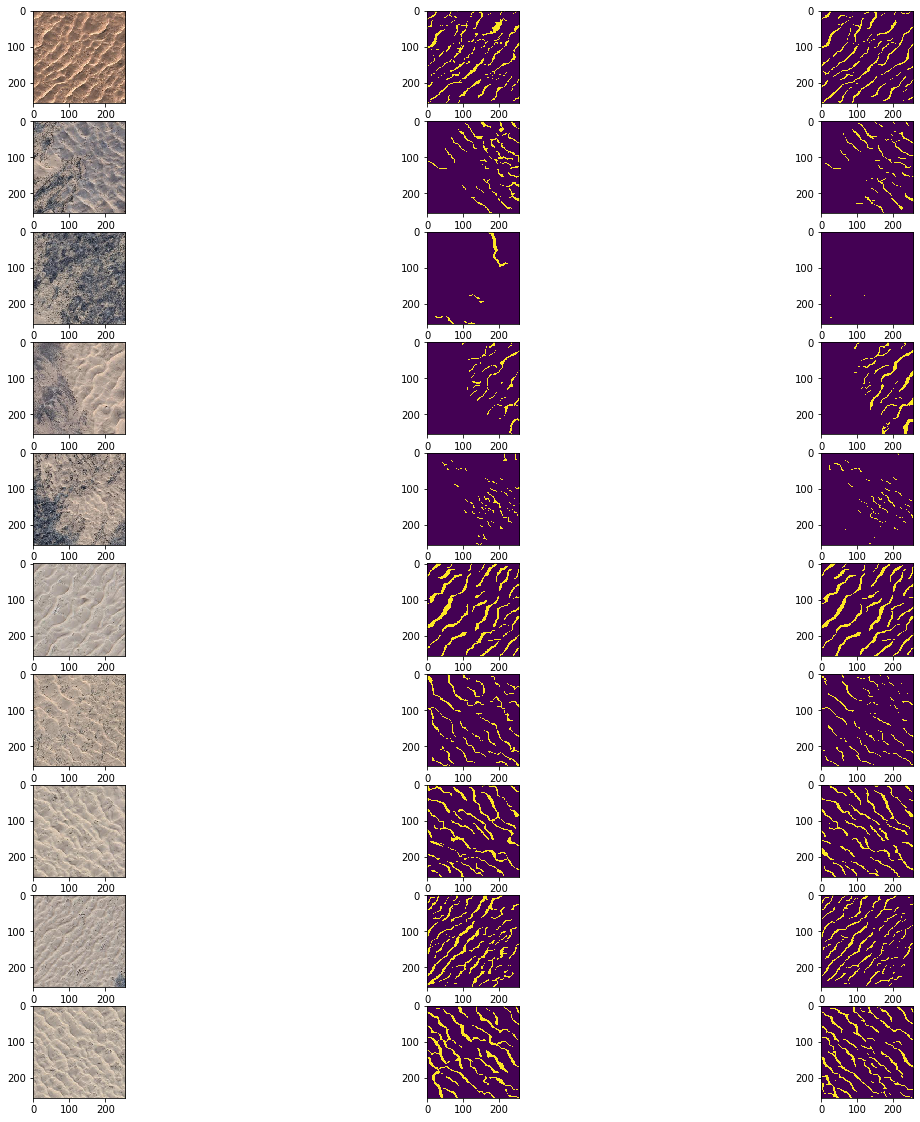

In [21]:
# 在训练数据上看效果：
num = 10 # 一次看5张效果！
new_model = tf.keras.models.load_model( '/home/gaoboyu/学习保存的模型/沙漠10_半网' )
for image, label_real in train_dataset.take(1):
    label_pred = new_model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    
    plt.figure( figsize=(20,20) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( (image[i].numpy() + 1)/2 )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(256,256) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy().reshape(256,256) )

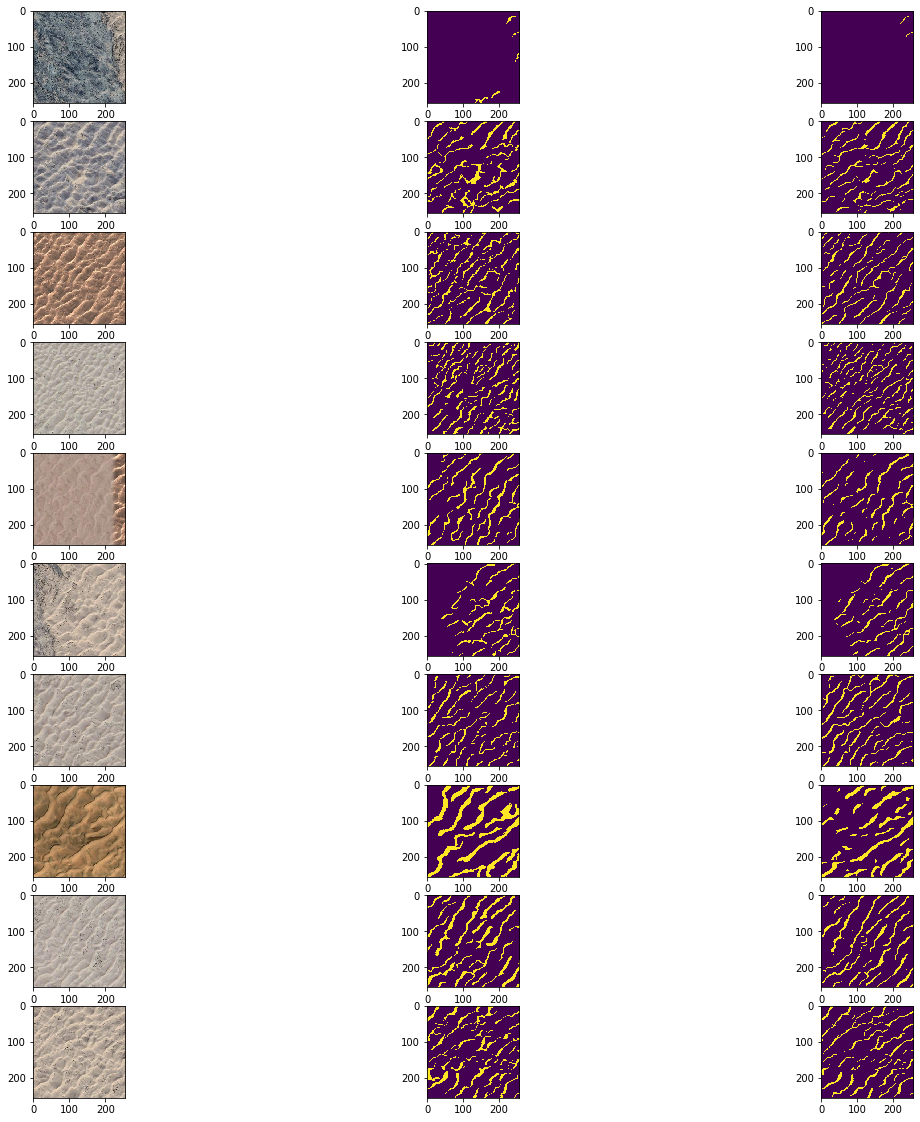

In [22]:
# 在训练数据上看效果：
num = 10 # 一次看5张效果！

for image, label_real in val_dataset.take(1):
    label_pred = new_model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    
    plt.figure( figsize=(20,20) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( (image[i].numpy() + 1)/2 )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(256,256) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy().reshape(256,256) )

In [24]:
new_model.evaluate( val_dataset )

6/6 [==============================] - 2s 317ms/step - loss: 0.2065 - acc: 0.9381


[0.20645198225975037, 0.9380638003349304]

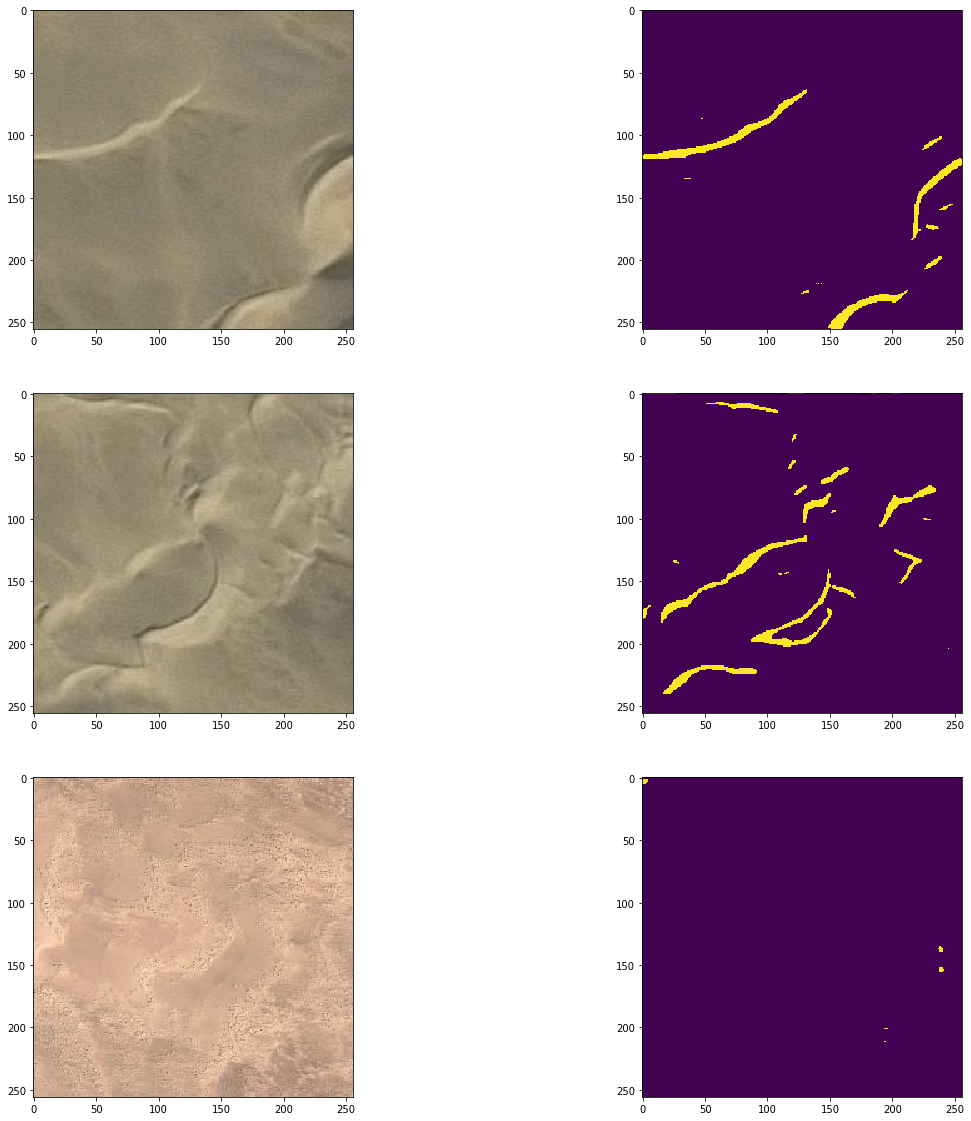

In [5]:
# 用当前模型测试一张图：
# new_model = tf.keras.models.load_model( '/home/gaoboyu/学习保存的模型/沙漠9_半网' )

img_test = glob.glob( r'/home/gaoboyu/学习数据集/另一区域/*.png' )
total_row = len(img_test)

plt.figure( figsize=(20,20) )
for x in range( total_row ):
    tmp = read_image( img_test[x] )
    tmp = tf.cast(tmp, tf.float32) / 127.5 - 1  # 归到[-1,1]之间！—— 和输入数据一致！
    tmp = tf.expand_dims( tmp, axis = 0 )

    label_pred = new_model.predict(tmp)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！

    tmp = tf.squeeze( tmp, axis = 0 )
    
    plt.subplot(total_row, 2, x*2 + 1)
    plt.imshow( (tmp.numpy() + 1)/2 )
    plt.subplot(total_row, 2, x*2 + 2)
    plt.imshow( label_pred[0].numpy().reshape(256,256) )

In [ ]:
# 降速训练3（0.00001/5）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.00001 / 5 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = total_epochs
final_epochs = 50  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

In [ ]:
# 降速训练4（0.00001/10）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.00001 / 10 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = total_epochs
final_epochs = 50  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

In [ ]:
# 备用模型保存函数 + 导入：保存当前模型 —— 临时保存在当前目录下。
model.save( 'model6_190_调过拟合_半网.h5' )
# new_model = tf.keras.models.load_model( 'model5_150_调过拟合_半网.h5' )

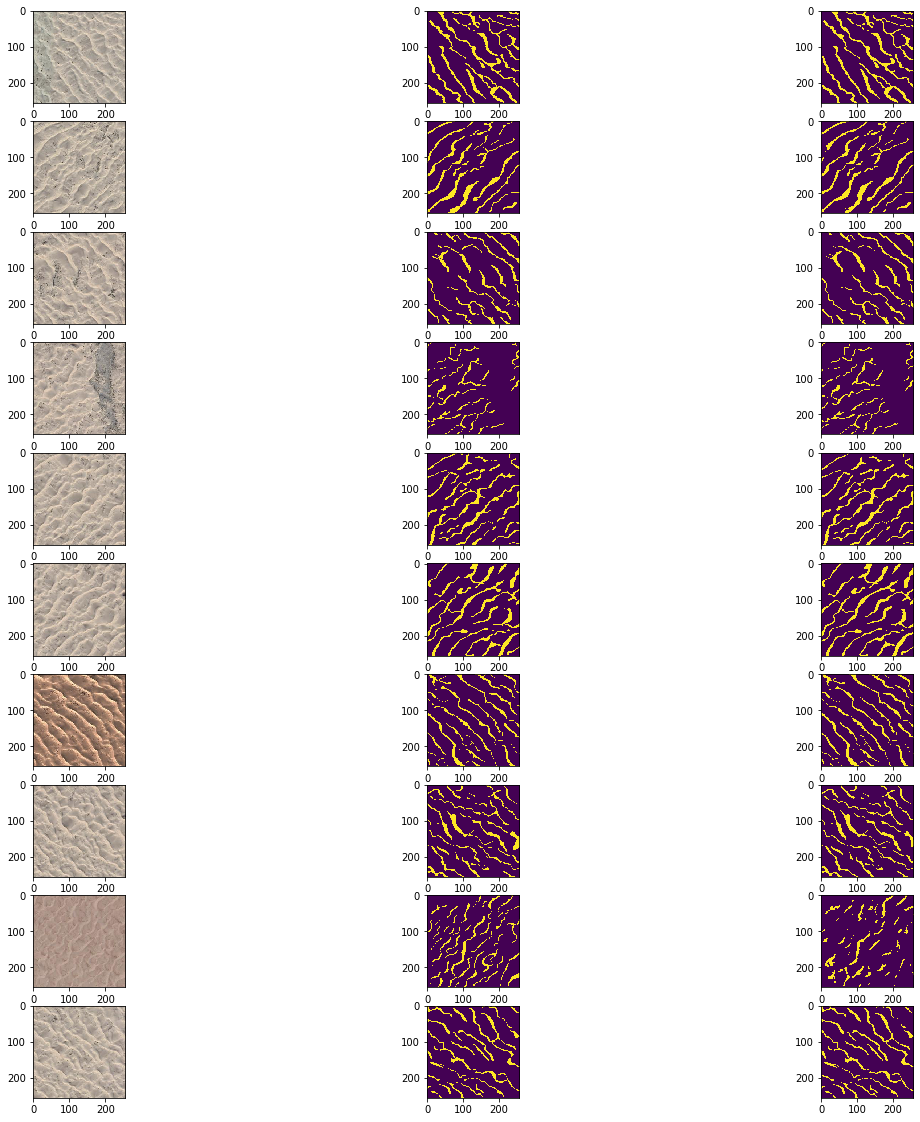

In [50]:
# 在训练数据上看效果：
num = 10 # 一次看5张效果！

for image, label_real in train_dataset.take(1):
    label_pred = new_model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    
    plt.figure( figsize=(20,20) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( (image[i].numpy() + 1)/2 )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(256,256) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy().reshape(256,256) )

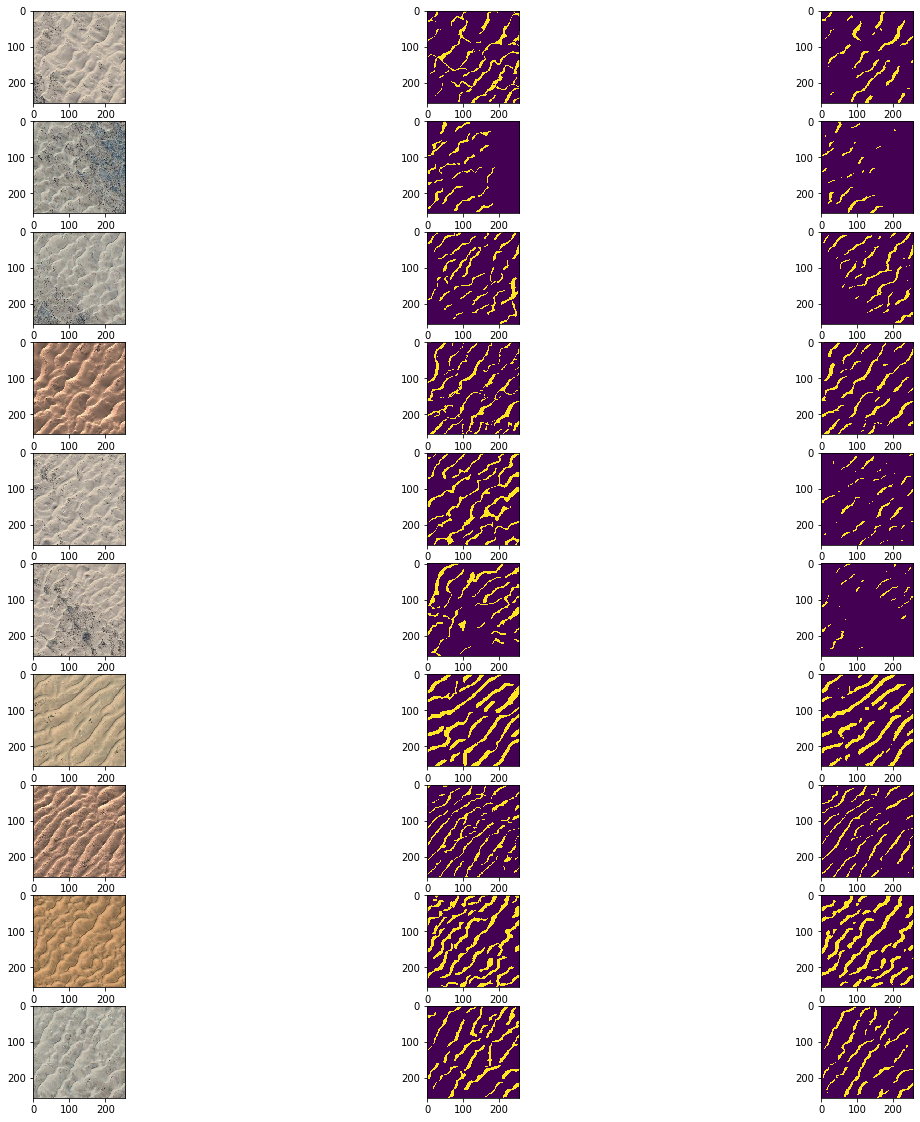

In [51]:
# 在训练数据上看效果：
num = 10 # 一次看10张效果！

for image, label_real in val_dataset.take(1):
    label_pred = new_model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    
    plt.figure( figsize=(20,20) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( (image[i].numpy() + 1)/2 )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(256,256) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy().reshape(256,256) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


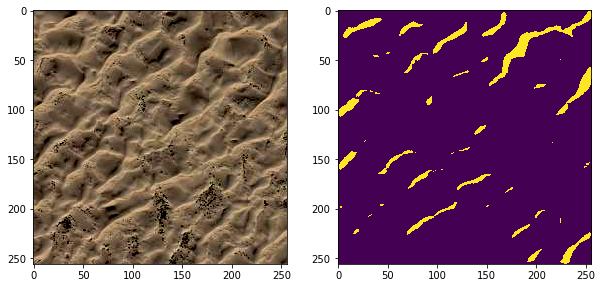

In [69]:
# 用当前模型测试一张图：
img_test = glob.glob( r'/home/gaoboyu/学习数据集/沙漠数据集3/subimg_212.png' )

img_test = read_image(img_test[0])
img_test = tf.cast(img_test, tf.float32) / 127.5 - 1  # 归到[-1,1]之间！—— 和输入数据一致！
img_test = tf.expand_dims( img_test, axis = 0 )

label_pred = new_model.predict(img_test)
label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！

img_test = tf.squeeze( img_test, axis = 0 )

plt.figure( figsize=(10,10) )
plt.subplot(1, 2, 1)
plt.imshow( img_test.numpy() )
plt.subplot(1, 2, 2)
plt.imshow( label_pred[0].numpy().reshape(256,256) )

In [65]:
img_test = tf.cast(img_test, tf.float32) / 127.5 - 1

In [66]:
img_test

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 0.09019613, -0.16862744, -0.30196077],
        [-0.02745098, -0.23921567, -0.3098039 ],
        [-0.00392157, -0.21568626, -0.2862745 ],
        ...,
        [ 0.2941177 ,  0.04313731, -0.1372549 ],
        [ 0.26274514,  0.0196079 , -0.14509803],
        [ 0.21568632, -0.02745098, -0.19215685]],

       [[ 0.09803927, -0.1607843 , -0.29411763],
        [-0.19999999, -0.42745095, -0.49019605],
        [-0.12156862, -0.34117645, -0.42745095],
        ...,
        [ 0.27843142,  0.03529418, -0.12941176],
        [ 0.23921573, -0.00392157, -0.16862744],
        [ 0.17647064, -0.04313725, -0.21568626]],

       [[ 0.09019613, -0.16862744, -0.30196077],
        [-0.16862744, -0.38823527, -0.47450978],
        [-0.05882353, -0.27843136, -0.372549  ],
        ...,
        [ 0.22352946, -0.01960784, -0.18431371],
        [ 0.1686275 , -0.05098039, -0.21568626],
        [ 0.12156868, -0.09803921, -0.26274508]],

       ...,

     

In [ ]:
# 备用模型保存函数 + 导入：保存当前模型 —— 临时保存在当前目录下。
model.save( '/home/gaoboyu/学习保存的模型/沙漠5/model5_150_调过拟合_半网.h5' )
# new_model = tf.keras.models.load_model( 'model5_150_调过拟合_半网.h5' )